### Chroma multimodal: https://docs.trychroma.com/guides/multimodal 

In [ ]:
# %pip install --upgrade chromadb
# %pip install pillow
# %pip install open-clip-torch
# %pip install tqdm
# %pip install matplotlib
# %pip install pandas


In [76]:
import chromadb 
import pandas as pd
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction 
from chromadb.utils.data_loaders import ImageLoader
from matplotlib import pyplot as plt 

In [77]:
chroma_client = chromadb.PersistentClient(path='chroma_vectordb')

image_loader = ImageLoader()
multimodal_ef = OpenCLIPEmbeddingFunction()
multmodal_db = chroma_client.get_or_create_collection(name="real_estate_mmdb", embedding_function=multimodal_ef, data_loader=image_loader)

In [78]:

column_names = ['num_bedrooms', 'num_bathrooms', 'area', 'zipcode', 'price']
df = pd.read_csv('./houses_dataset/Houses Dataset/HousesInfo.txt', delimiter=' ', header=None, names=column_names)

In [79]:
print(df.head(5))

   num_bedrooms  num_bathrooms  area  zipcode   price
0             4            4.0  4053    85255  869500
1             4            3.0  3343    36372  865200
2             3            4.0  3923    85266  889000
3             5            5.0  4022    85262  910000
4             3            4.0  4116    85266  971226


In [80]:
total_num_houses = 535
ids = []
uris = []
metadatas = []
for i in range(total_num_houses):
    ids.append(str(i))
    uris.append('houses_dataset/Houses Dataset/' + str(i+1) + '_frontal.jpg')
    metadatas.append(
            {
                'number_of_bedrooms': str(df.iloc[i, 0]), 
                'number_of_bathrooms': str(df.iloc[i, 1]), 
                'area': str(df.iloc[i, 2]),
                'zipcode': str(df.iloc[i, 3]),
                'price': str(df.iloc[i, 4])
            }        
    )

In [81]:
print(ids[:10])
print(uris[:10])
print(metadatas[:10])

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['houses_dataset/Houses Dataset/1_frontal.jpg', 'houses_dataset/Houses Dataset/2_frontal.jpg', 'houses_dataset/Houses Dataset/3_frontal.jpg', 'houses_dataset/Houses Dataset/4_frontal.jpg', 'houses_dataset/Houses Dataset/5_frontal.jpg', 'houses_dataset/Houses Dataset/6_frontal.jpg', 'houses_dataset/Houses Dataset/7_frontal.jpg', 'houses_dataset/Houses Dataset/8_frontal.jpg', 'houses_dataset/Houses Dataset/9_frontal.jpg', 'houses_dataset/Houses Dataset/10_frontal.jpg']
[{'number_of_bedrooms': '4', 'number_of_bathrooms': '4.0', 'area': '4053', 'zipcode': '85255', 'price': '869500'}, {'number_of_bedrooms': '4', 'number_of_bathrooms': '3.0', 'area': '3343', 'zipcode': '36372', 'price': '865200'}, {'number_of_bedrooms': '3', 'number_of_bathrooms': '4.0', 'area': '3923', 'zipcode': '85266', 'price': '889000'}, {'number_of_bedrooms': '5', 'number_of_bathrooms': '5.0', 'area': '4022', 'zipcode': '85262', 'price': '910000'}, {'number_of_bedrooms

In [90]:
num_houses = 100
multmodal_db.update(                                                # add: to add first time, update: to update
    ids = ids[:num_houses],
    uris = uris[:num_houses],
    metadatas = metadatas[:num_houses]
)

In [83]:
multmodal_db.count()

10

In [84]:
def print_query_results(query_list: list, query_results: dict)->None:
    result_count = len(query_results['ids'][0])

    for i in range(len(query_list)):
        print(f'Results for query: {query_list[i]}')

        for j in range(result_count):
            id       = query_results["ids"][i][j]
            distance = query_results['distances'][i][j]
            data     = query_results['data'][i][j]
            document = query_results['documents'][i][j]
            metadata = query_results['metadatas'][i][j]
            uri      = query_results['uris'][i][j]

            print(f'id: {id}, distance: {distance}, metadata: {metadata}, document: {document}') 
            print(f'data: {uri}')
            plt.imshow(data)
            plt.axis("off")
            plt.show()

Results for query: houses with 2 bedroom
id: 93, distance: 1.528762698173523, metadata: {'area': '1499', 'number_of_bathrooms': '2.5', 'number_of_bedrooms': '2', 'price': '539000', 'zipcode': '91901'}, document: None
data: houses_dataset/Houses Dataset/94_frontal.jpg


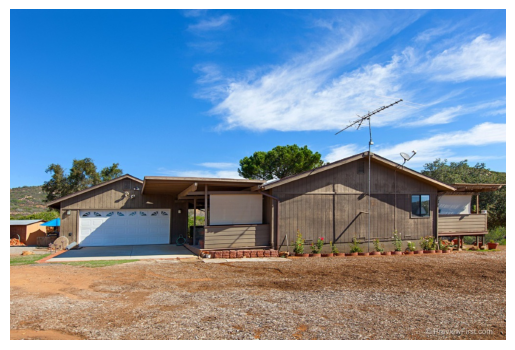

id: 82, distance: 1.5332601070404053, metadata: {'area': '1184', 'number_of_bathrooms': '1.0', 'number_of_bedrooms': '2', 'price': '397500', 'zipcode': '91901'}, document: None
data: houses_dataset/Houses Dataset/83_frontal.jpg


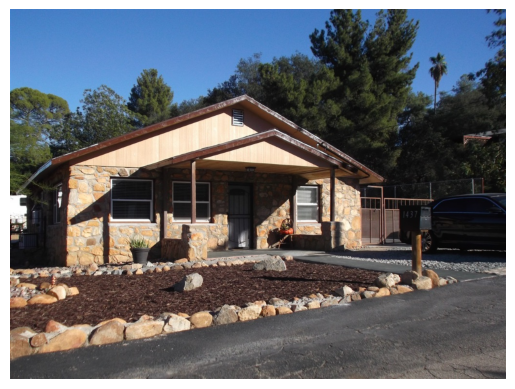

id: 81, distance: 1.6159662008285522, metadata: {'area': '1845', 'number_of_bathrooms': '2.0', 'number_of_bedrooms': '2', 'price': '529800', 'zipcode': '91901'}, document: None
data: houses_dataset/Houses Dataset/82_frontal.jpg


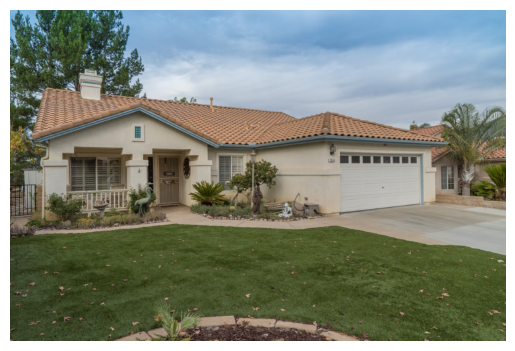

In [92]:
query_texts=['houses with 2 bedroom']
num_bedroom = '2'

query_results = multmodal_db.query(
    query_texts = query_texts,
    n_results = 5, 
    include=['documents', 'distances', 'metadatas', 'data', 'uris'],
    where={'number_of_bedrooms':{'$eq':num_bedroom}}
)
print_query_results(query_texts, query_results)